In [1]:
import os
import io
import time
import pickle
import pandas as pd
import numpy as np

import cv2
from skimage import transform
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


image_dir = r"C:\Users\Leo's PC\Desktop\images"
csv_dir = r"C:\Users\Leo's PC\Desktop\AVA.txt"

device = 'cuda:1'

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#### I forgot what this is. DO NOT initialize.

In [2]:
'''
FasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True, pretrained_backbone=True)

num_classes = 60
in_features = FasterRCNN.roi_heads.box_predictor.cls_score.in_features

FasterRCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

'''

'\nFasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True, pretrained_backbone=True)\n\nnum_classes = 60\nin_features = FasterRCNN.roi_heads.box_predictor.cls_score.in_features\n\nFasterRCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)\n\n'

#### pytorch 1.5.1 is required to run the following // idk why still can't pass trainable_backbone_layers in

In [3]:
print(torch.__version__)

1.6.0+cu101


In [4]:
#FasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=60, pretrained_backbone=True, trainable_backbone_layers=3)

#MaskRCNN = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=10, pretrained_backbone=True, trainable_backbone_layers=3)

#KeypointRCNN = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=2, num_keypoints=17, pretrained_backbone=True, trainable_backbone_layers=3)

#### for Pytorch 1.5.0 ==>no trainable_backbone_layers as parameter

In [2]:
#FasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=60,
                #pretrained_backbone=True)
#MaskRCNN = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=10, 
                #pretrained_backbone=True)
KeypointRCNN = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=2, num_keypoints=17, pretrained_backbone=True)

In [3]:
def to_variable(x,requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x,requires_grad)

to_tensor = transforms.ToTensor()

def show(img): # Display rgb tensor image
    pilTrans = transforms.ToPILImage()
    pilImg = pilTrans(img)
    s = np.array(pilImg)
    plt.figure()
    plt.imshow(s)
    
def show_gray(img): # Display grayscale tensor image
    pilTrans = transforms.ToPILImage()
    pilImg = pilTrans(img)
    s = np.array(pilImg)
    
    cv2.namedWindow( "Display window", cv2.WINDOW_AUTOSIZE)
    cv2.imshow("Display window", s)
    cv2.waitKey(0)
    
    '''
    plt.figure()
    plt.imshow(s)
    '''
    
def predict(model, img):
    im = to_tensor(img)
    im = to_variable(im.unsqueeze(0), False)
    im = im.cuda()
    im = im.to(torch.device(device))
    out = model(im)
    return out

def show_img_from_path(imgPath):
    pilImg = Image.open(imgPath)
    size = np.array(pilImg.size)
    size = np.append(size, 3).reshape(3)
    print(size)
    s = np.array(pilImg)
    plt.figure()
    plt.imshow(s)

[800 530   3]


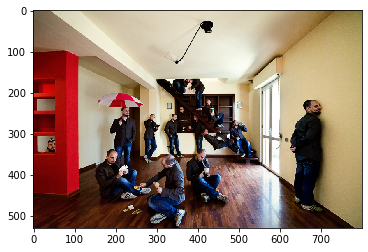

In [4]:
sample_img_path = 'Sample Images/example13.jpg'
show_img_from_path(sample_img_path)

C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torchvision\ops\boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


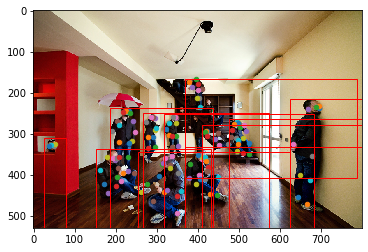

In [5]:
KeypointRCNN.eval()
KeypointRCNN.to(torch.device(device))

img = Image.open(sample_img_path)

predictions = predict(KeypointRCNN, img)

# Get the current reference
ax = plt.gca()

threshold = 0.93
kpt_score_threshold = 5

patches = []
idx = 0
for box in predictions[0]['boxes']:
    if predictions[0]['scores'][idx] >= threshold:
        rect = plt.Rectangle((box[0],box[1]),box[2],box[3],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    idx += 1


box_idx = 0
for dot_group in predictions[0]['keypoints']:
    point_idx = 0
    for dot in dot_group:
        if predictions[0]['keypoints_scores'][box_idx][point_idx] >= kpt_score_threshold:
            if predictions[0]['scores'][box_idx] >= threshold:
                dot = plt.scatter(dot[0].cpu().detach().numpy(), dot[1].cpu().detach().numpy(), s=20)
        point_idx += 1
    box_idx += 1

    
plt.imshow(img)
# plt.savefig(r'Sample Images\12.jpg')

In [ ]:
## KeypointRCNN.eval()
KeypointRCNN.to(torch.device(device))
x = torch.rand(3, 300, 400).unsqueeze(0)
x = x.to(torch.device(device))
x = x.cuda()

print('Input:', type(x), x.shape)

print(KeypointRCNN(x))

## Code for processing the entire AVA dataset

- will produce 17 feature maps, one for each joint
- COCO_PERSON_KEYPOINT_NAMES = [
    'nose',
    'left_eye',
    'right_eye',
    'left_ear',
    'right_ear',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist',
    'left_hip',
    'right_hip',
    'left_knee',
    'right_knee',
    'left_ankle',
    'right_ankle'
]

- What about the dot size if the maps are going to be resized?

In [ ]:
'''
create a array with 17 rows, each row representing the points for each joint feature map
each row will have 0-13 elements
each element will be [x,y]
'''

def KeyPointRCNNAVA(csv_file, save_dir):
    
    csv = pd.read_csv(csv_file, sep=' ')
    
    for _, _, files in os.walk(image_dir): #get a list of file names in the dataset folder
        img_name_array = files
    
    for csv_idx, row in csv.iterrows(): #traverse the enitre csv file
        img_name = row[1]
        if (str(img_name) + '.jpg') in img_name_array:
            img = Image.open(os.path.join(image_dir, str(img_name) + '.jpg'))
            size = np.flip(np.array(img.size))
            img = np.array(img)
            
            try:
                predictions = predict(KeypointRCNN, img)
            except TypeError:
                print("Image reading: TypeError. Skipped")
            else:
                

                sal_predicted = np.array(sal_predicted * 255, dtype='uint8')
            
                folder_path = os.path.join(save_dir,str(img_name))

                if not os.path.exists(folder_path):
                    os.mkdir(folder_path)
                else: print("Path exists: Overwriting...")


                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                cv2.imwrite(os.path.join(folder_path, '0' + '.jpg'), img)
                cv2.imwrite(os.path.join(folder_path, '1' + '.jpg'), sal_predicted)
                if csv_idx % 10000 == 0:
                    print('==> csv_idx:', csv_idx)